In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import math

## Mathematical model of the immune response activation including cortisol and glucose dynamics


#### Obs: All the rates are represented per day

In [2]:
# Initial Conditions by experimental data

A = 2                  # Cell/mm3 # S. aureus Bacteria               
MA = 5                 #  -       # Macrophages activated
MR = 10                # Cell/mm3 # Macrophages resting
F = 1                  #  -       # Antibodies
IL_6 = 0               #          # Interleukin-6 (pro-inflammatory)
IL_8 = 0               #          # Interleukin-8 (pro-inflammatory)
IL_10 = 0.7            #          # Interleukin-10 (anti-inflammatory)
TNF = 0.17             #          # Tumor Necrosis Factor a (pro-inflammatory)     
MR_max = 5             #          # Macrophages resting max  



# Initial Conditions of Each Equation
y0 = [A, MA, MR, F, IL_10, IL_6, IL_8, TNF]


## Parameters by Brady et al., (2016):


In [3]:
n_106 = 560            # pg/mL    # Half-maximum value associated with upregulation of IL-10 by IL-6
n_610 = 34.8           # pg/mL    # Half-maximum value associated with downregulation of IL-6 by IL-10
n_66 = 560             # pg/mL    # Half-maximum value associated with the auto-negative feedback of IL-6
n_6TNF = 185           # pg/mL    # Half-maximum value associated with upregulation of IL-6 by TNF-a
n_TNF6 = 560           # pg/mL    # Half-maximum value associated with downregulation of TNF-a by IL-6
n_810 = 17.4           # pg/mL    # Half-maximum value associated with downregulation of IL-8 by IL-10
n_8TNF = 185           # pg/mL    # Half-maximum value associated with upregulation of IL-8 by TNF-a
n_M10 = 4.35           # pg/mL    # 
n_TNF10 = 17.4         # pg/mL    # Half-maximum value associated with downregulation of TNF-a by IL-10
n_MTNF = 0.1           # ?        #  
# n_MTNF = 100  pg/mL (Brady et al., 2016 value)
h_106 = 3.68           # -        # Hill function exponent associated with upregulation of IL-10 by IL-6
h_610 = 4              # -        # Hill function exponent associated with downregulation of IL-6 by IL-10
h_66 = 1               # -        # Hill function exponent associated with auto-negative feedback of IL-6
h_6TNF = 2             # -        # Hill function exponent associated with upregulation of IL-6 by TNF-a
h_TNF6 = 2             # -        # Hill function exponent associated with downregulation of TNF-a by IL-6
h_810 = 1.5            # -        # Hill function exponent associated with downregulation of IL-8 by IL-10
h_8TNF = 3             # -        # Hill function exponent associated with upregulation of IL-8 by TNF-a
h_M10 = 0.3            # -        # 
h_TNF10 = 3            # -        # Hill function exponent associated with downregulation of TNF-a by IL-10
h_MTNF = 3.16          # -        # 
k_MA = 2.51            #          # 
k_MR = 6               #          # 
k_m = 0.0414           #          # 
# k_106 = 0.191 Matlab value
k_106 = 0.0191         # relative cytokine concentration/(day · # of cells)    # Upregulation of IL-10 by IL-6
k_6 = 4.64             # day-1                                                 # Activation rate (per hour) of IL-6
k_6m = 0.01            # relative cytokine concentration/(day · # of cells)    # Upregulation of IL-6 by the activated macrophages
k_6TNF = 0.81          # relative cytokine concentration/(day · # of cells)    # Upregulation of IL-6 by TNF-a
k_8 = 0.464            # day-1                                                 # Activation rate (per hour) of IL-8
k_8m = 0.056           # relative cytokine concentration/(day · # of cells)    # Upregulation of IL-8 by the activated macrophages
k_8TNF = 0.56          # relative cytokine concentration/(day · # of cells)    # Upregulation of IL-8 by TNF-a
k_10 = 1.1             # day-1                                                 # Activation rate (per hour) of IL-10
k_10m = 0.19           # relative cytokine concentration/(day · # of cells)    # Upregulation of IL-10 by the activated macrophages
k_TNF = 200            # day–1                                                 # Activation rate (per hour) of TNF-a
k_TNFM = 1.5           # relative cytokine concentration/(day · # of cells)    # Upregulation of TNF-a by the activated macrophages
k_MTNF = 8.65          # hr-1                                                  # Activation rate of resting macrophages influenced by
q_IL6 = 0.6            # relative concentration                                # The concentration of IL-6 in the absence of a pathogen
q_IL8 = 0.2            # relative concentration                                # The concentration of IL-8 in the absence of a pathogen
q_IL10 = 0.15          # relative concentration                                # The concentration of IL-10 in the absence of a pathogen
q_TNF = 0.14           # relative concentration                                # The concentration of TNF-a in the absence of a pathogendescription

## Parameters by Quintela et al., (2014):

In [4]:
Th = 0                          # -               # T-lymphocytes (T)
B = 0                           # -               # B-lymphocytes (B)
# In the Reference: P = 0
P = 4                           # -               # plasma cells (P)
F_T = 0                         # -               # Is the average number of antibodies in the tissue
F_L = 0                         # -               # Antibodies released by plasma cells
A_T = A                         # Cell/mm3        # S. aureus Bacteria
d_a = 0.000037                  # mm^3/day        # Bacteria diffusion coefficient
d_mr = 0.0432                   # mm^3/day        # Resting macrophage diffusion coefficient
d_ma = 0.3                      # mm^3/day        # Activated macrophage diffusion coefficient
d_f = 0.016                     # mm^3/day        # Rate the diffusion process of antibodies in the tissue
# In Reference: beta_A = 2
beta_A = 0.02                   # 1/day           # Replication rate of the bacteria
k_A = 50.0                      # mm^3/day        # Carrying capacity of the bacteria
#In Reference: m_A = 0.1
m_A = 0.9                        # 1/day          # Natural decay rate of the bacteria
m_Mr = 0.033                     # 1/day          # Natural decay rate of the resting macrophages
m_Ma = 0.07                      # 1/day          # Natural decay rate of the activated macrophages
alpha_f = 0.43                   # 1/day          # Antibodies migration rate
lambda_afma = 7.14 * pow(10, -2) # mm6/cell2*day  # Activated macrophage phagocytosis rate of opsonized antigen
lambda_afmr = 1.66 * pow(10, -3) # mm6/cell2*day  # Resting macrophage phagocytosis rate of opsonized antigen

*Elliot Code:*
## Parameters by Uluseker C et al, (2018):

In [5]:
# Simulation Parameters
sim_time = 1         # min/day        # Total time of simulation in min 
deltaT = pow(10, -4)   # -              # Step size

t = np.arange(0,sim_time,deltaT)
#t= np.arange(0,525960) #1 day == 1440min   # 365 year == 525600min
#t= np.arange(0,1400) #24 hours, 1 datapoint per minute ELLIOT

## ODE System

In [6]:
def f(y, t):
    A = y[0]
    MA = y[1]
    MR = y[2]
    F = y[3]
    IL10 = y[4]
    IL6 = y[5]
    IL8 = y[6]
    TNF = y[7]

    dAdt = (beta_A * A *(1 - (A / k_A)) - m_A * A * MA)
    
    dMAdt = ((k_m + k_MTNF * pow(TNF, h_MTNF) / (pow(n_MTNF, h_MTNF) + pow(TNF, h_MTNF)) * (pow(n_M10, h_M10) / (pow(n_M10, h_M10)\
         + pow(IL10, h_M10)))) * MR * A - k_MA * MA)
    
    dMRdt = ((-(k_m + k_MTNF * (pow(TNF, h_MTNF) / (pow(n_MTNF, h_MTNF) + pow(TNF, h_MTNF))) * (pow(n_M10, h_M10) / (pow(n_M10, h_M10)\
         + pow(IL10, h_M10)))) * MR * A + k_MR * MR) + k_MR * MR * (1 - MR / MR_max))
    
    dFdt = (-(lambda_afma * F * A * MA) - (lambda_afmr * F * A * MR) - (alpha_f * F))
    
    dIL10dt = ((k_10m + k_106 * (pow(IL6, h_106) / (pow(n_106, h_106) + pow(IL6, h_106)))) * MA - k_10 * (IL10 - q_IL10))
    
    dIL6dt = ((k_6m + k_6TNF * (pow(TNF, h_6TNF) / (pow(n_6TNF, h_6TNF) + pow(TNF, h_6TNF))) * (pow(n_66, h_66) / (pow(n_66, h_66)\
         + pow(IL6, h_66))) * (pow(n_610, h_610) / (pow(n_610, h_610) + pow(IL10, n_610)))) * MA - k_6 * (IL6 - q_IL6))
    
    dIL8dt = ((k_8m + k_8TNF * (pow(TNF, h_8TNF) / (pow(TNF, h_8TNF) + pow(n_8TNF, h_8TNF))) * (pow(n_810, h_810) / (pow(n_810, h_810)\
         + pow(IL10, h_810)))) * MA - k_8 * (IL8 - q_IL8))
    
    dTNFdt = ((k_TNFM * (pow(n_TNF6, h_TNF6) / (pow(n_TNF6, h_TNF6) \
              + pow(IL6, h_TNF6))) * (pow(n_TNF10, h_TNF10) / (pow(n_TNF10, h_TNF10)\
              + pow(IL10, h_TNF10)))) *  MA - k_TNF * (TNF - q_TNF))
     

    return [dAdt, dMAdt, dMRdt, dFdt, dIL10dt, dIL6dt, dIL8dt, dTNFdt]

# Solution with odeint() function
sol = odeint(f, y0, t)
out_A = sol[:, 0]
out_MA = sol[:, 1]
out_MR = sol[:, 2]
out_F = sol[:, 3]
out_IL10 = sol[:, 4]
out_IL6 = sol[:, 5]
out_IL8 = sol[:, 6]
out_TNF = sol[:, 7]


# Normalization
out_TNF = 100 * (out_TNF - min(out_TNF)) / (max(out_TNF) - min(out_TNF))
out_IL6 = 100 * (out_IL6 - min(out_IL6)) / (max(out_IL6) - min(out_IL6))
out_IL8 = 100 * (out_IL8 - min(out_IL8)) / (max(out_IL8) - min(out_IL8))
out_IL10 = 100 * (out_IL10 - min(out_IL10)) / (max(out_IL10) - min(out_IL10))

## Plots: 

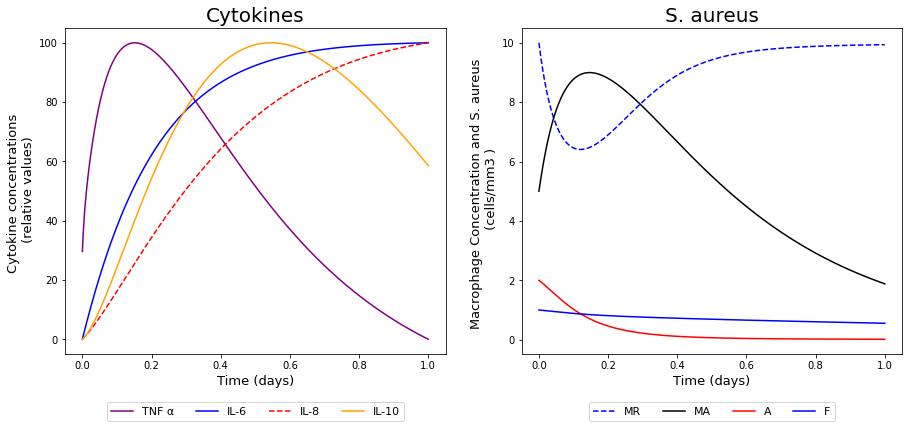

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2)
#fig.suptitle("Python Charts", fontsize = 25)

# Cytokines
ax1.plot(t, out_TNF,'purple', label="TNF α")
ax1.plot(t, out_IL6, 'b', label="IL-6")
ax1.plot(t, out_IL8, 'r--', label="IL-8")
ax1.plot(t, out_IL10, 'orange', label="IL-10")

ax1.set_title("Cytokines", fontsize = 20)
ax1.legend( ncol = 4, bbox_to_anchor = (0.5,-0.13), loc='upper center', fontsize = 11)
ax1.set_xlabel('Time (days)', fontsize = 13)
ax1.set_ylabel('Cytokine concentrations \n (relative values)', fontsize = 13)

# S. aureus
ax2.plot(t, out_MR, 'b--', label="MR")
ax2.plot(t, out_MA, 'black', label="MA")
ax2.plot(t, out_A,'r', label="A")
ax2.plot(t, out_F,'b', label="F")

ax2.set_title("S. aureus", fontsize = 20)
ax2.legend( ncol = 4, bbox_to_anchor = (0.5,-0.13), loc='upper center', fontsize = 11)
ax2.set_xlabel('Time (days)', fontsize = 13)
ax2.set_ylabel('Macrophage Concentration and S. aureus \n (cells/mm3 )', fontsize = 13)


fig.set_figwidth(15) 
fig.set_figheight(6) 

plt.show()